In [1]:
# from gen_results import metric
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def metric(seeds_dir, error_name='l1', verbose=False):
    # average of last 10 epochs
    results_path = Path(seeds_dir)

    if verbose:
        print(results_path.name)

    run_logs = []
    for path in results_path.glob('*/logs.json'):
        if verbose:
            print(path)
        with open(path, 'r') as logfile:
            try:
                run_logs.append(pd.read_json(logfile))
            except ValueError as e:
                raise ValueError(f'cant read json {path}: {e}')

    if not run_logs:
        return None

    logs = pd.concat(run_logs, ignore_index=True)
    epoch = logs['epoch']
    sender = pd.DataFrame(logs['sender'].tolist()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].tolist()).join(logs['epoch'])
    if error_name == 'l1' and 'test_l1_error' in sender:
        error_metric = 'test_l1_error'
    elif error_name == 'l2' and 'test_l2_error' in sender:
        error_metric = 'test_l2_error'
    elif error_name == 'train':
        error_metric = 'test_error'
    else:
        raise Exception(f'error name {error_name} either not found or not valid')

    last_10 = logs['epoch'] >= 20
    return sender[last_10][error_metric].mean(), recver[last_10][error_metric].mean()


def all_metrics(path):
    all_results_path = Path(path)

    sender_l1 = []
    recver_l1 = []
    errors = []
    for result_dir in all_results_path.iterdir():
        if result_dir.is_dir():
            try:
                s1, r1 = metric(result_dir)
            except:
                errors.append(result_dir.name)
            else:
                sender_l1.append(s1*10)
                recver_l1.append(r1*10)
    
    return sender_l1, recver_l1

In [4]:
log_path = Path('../full_logs')
results_path = Path('../results')

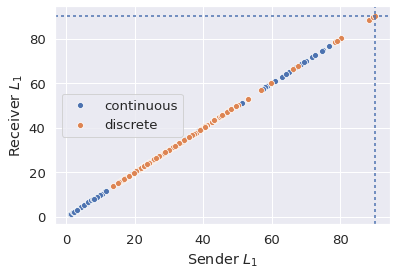

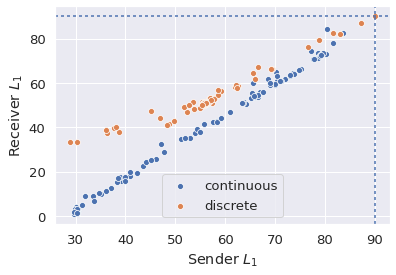

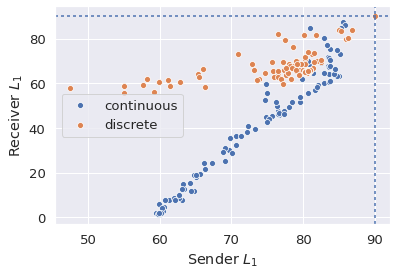

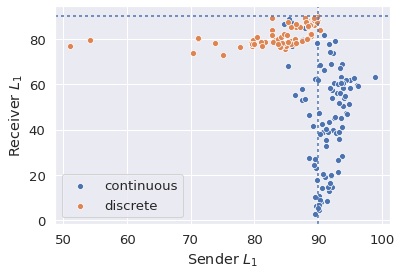

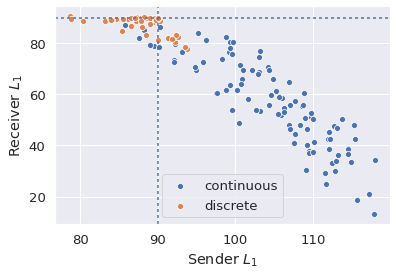

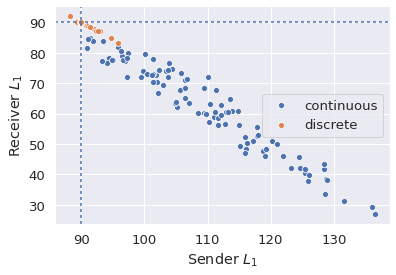

In [5]:
for bias in [0,3,6,9,12,15]:
    with sns.plotting_context('paper'):
        path = log_path / f'gauss-deter-dim1-bias{bias}'
        sender_l1, recver_l1 = all_metrics(path)
        sns.set(font_scale=1.2)
        sns.scatterplot(sender_l1,recver_l1, label='continuous')
        plt.xlabel(r'Sender $L_1$')
        plt.ylabel(r'Receiver $L_1$')

        path = log_path / f'cat-deter-bias{bias}'
        sender_l1, recver_l1 = all_metrics(path)
        sns.set(font_scale=1.2)
        sns.scatterplot(sender_l1,recver_l1, label='discrete')
        plt.xlabel(r'Sender $L_1$')
        plt.ylabel(r'Receiver $L_1$')

        plt.axvline(90, dashes=(2,2,2,2))
        plt.axhline(90, dashes=(2,2,2,2))

#         plt.savefig(results_path / f'cont_v_discrete_bias{bias}.png',  bbox_inches='tight')
        plt.show()